In [1]:
import torch
import numpy             as np
import matplotlib.pyplot as plt

from sympy                    import *
from sympy                    import symbols, diff, simplify, exp, tanh, lambdify
from torch.optim              import Adam, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm                     import tqdm

init_printing()

# 1. Initialize

In [11]:
# Coordinates
r, theta, phi = symbols('r, theta, phi')
coords = [r, theta, phi]


# Horizon function
#h = Function('h')(theta, phi)
h = Function('h')(theta)


# Additional symbols
N = symbols('N')
M = symbols('M')
R = symbols('R')


# ADM 3+1 components
alpha = Function('alpha')(r, theta, phi)   # lapse function
alpha = (1-M/(2*r)) / (1+M/(2*r))
#alpha = 1

beta = Array([0,0,0])                       # Shift vector

psi = Function('psi')(r, theta, phi)       # Conformal factor
psi = 1 + M/(2*r)
#psi = 1
psi4 = psi**4


# Flat metric and inverse
eta = diag(1, r**2, (r*sin(theta))**2)
eta_inv = eta**(-1)

***

# 2. Calculate expansion equation

In [ ]:
# Run the file with all help functions

%run Apparent_horizon_conformal.ipynb

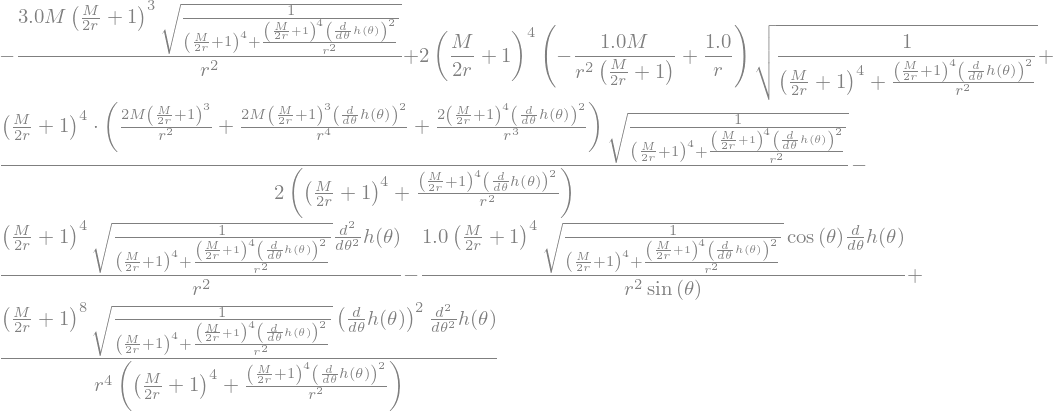

In [20]:
'''
Large function which calculates the expansion equation from alpha, beta, psi4, coordinates and h
'''



def final(alpha, beta, psi4, coords, h):
    '''
    param alpha: lapse function      --> function of (r, theta, phi)
    param beta: shift vector         --> 3-vector function of (r, theta, phi)
    param psi4: conformal factor     --> function of (r, theta, phi)
    param coords: coordinate system  --> list of coordinates
    param h: horizon function        --> scalar function dependent on theta, phi

    return: symbolic sympy expression of the expansion equation
    '''

    
    s_inv_norm = s_norm(h, psi4, coords, eta_inv)                       # inverse s-vector (normalized)
    
    christoffel = christoffel_symbols(psi4, eta, eta_inv, coords)       # Christoffel symbols of gamma 3-metric
    
    n_up = norm_up(alpha, beta, coords)                                 # normal vector to hypersurface (index up)
    
    n_down = norm_down(alpha, beta, psi4, eta, coords)                  # normal vector to hypersurface (index down)
    
    cur = extrinsic_curvature(n_up, n_down, christoffel, coords)        # extrinsic curvature (K_ij)
    
    exp = expansion(christoffel, s_inv_norm, cur, coords)               # expansion equation

    
    return exp



exp_eq = final(alpha, beta, psi4, coords, h)
display(exp_eq)

***

# 3. Convert symbolic expression to string (pytorch compatible)

In [21]:
'''
Function which replaces theta derivatives with symbols
'''



from sympy.printing.lambdarepr import lambdarepr


# Define functions and symbols (--> up to 5th order derivatives can be replaced)
x = Function('x')(theta)
y = Function('y')(theta)
z = Function('z')(theta)
u = Function('u')(theta)
v = Function('v')(theta)
H, X, Y, Z, U, V = symbols('H, X, Y, Z, U, V')
funcs_pre = [h, x, y, z, u, v]
syms_pre = [H, X, Y, Z, U, V]


# Replace each theta derivative with a unique symbol for string conversion
def subs_der(expr, nr_der):
    '''
    params expr: symbolic expression in which to replace derivatives
    params nr_der: highest order of desired derivative to be replaced

    return: string with r replaced by H and derivatives replaced by symbols X, Y, ...
    '''
    
    funcs = []
    syms = []
    for i in range(nr_der+1):
        funcs.append(funcs_pre[i])
        syms.append(syms_pre[i])
    n = len(funcs)
    expr = expr.subs(r, h)
    for i in range(n-1):
        expr = expr.subs(diff(funcs[i], theta), funcs[i+1])
    for i in range(n):
        expr = expr.subs(funcs[i], syms[i])
        
    return lambdarepr(expr)

symp_expr = subs_der(exp_eq, 2)
print(symp_expr)

2*(1 + (1/2)*M/H)**4*(1.0/H - 1.0*M/(H**2*(1 + (1/2)*M/H)))*sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2)) + (1/2)*(1 + (1/2)*M/H)**4*(2*M*(1 + (1/2)*M/H)**3/H**2 + 2*X**2*(1 + (1/2)*M/H)**4/H**3 + 2*M*X**2*(1 + (1/2)*M/H)**3/H**4)*sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2) - 3.0*M*(1 + (1/2)*M/H)**3*sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))/H**2 - 1.0*X*(1 + (1/2)*M/H)**4*sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))*math.cos(theta)/(H**2*math.sin(theta)) - Y*(1 + (1/2)*M/H)**4*sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))/H**2 + X**2*Y*(1 + (1/2)*M/H)**8*sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))/(H**4*((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))


In [23]:
'''
Function which makes the string pytorch-compatible
'''


dic = {"math.":"torch.", "sqrt":"torch.sqrt"}

def replace_all(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(symp_expr, dic)
print(expr)

2*(1 + (1/2)*M/H)**4*(1.0/H - 1.0*M/(H**2*(1 + (1/2)*M/H)))*torch.sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2)) + (1/2)*(1 + (1/2)*M/H)**4*(2*M*(1 + (1/2)*M/H)**3/H**2 + 2*X**2*(1 + (1/2)*M/H)**4/H**3 + 2*M*X**2*(1 + (1/2)*M/H)**3/H**4)*torch.sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2) - 3.0*M*(1 + (1/2)*M/H)**3*torch.sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))/H**2 - 1.0*X*(1 + (1/2)*M/H)**4*torch.sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))*torch.cos(theta)/(H**2*torch.sin(theta)) - Y*(1 + (1/2)*M/H)**4*torch.sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))/H**2 + X**2*Y*(1 + (1/2)*M/H)**8*torch.sqrt(1/((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))/(H**4*((1 + (1/2)*M/H)**4 + X**2*(1 + (1/2)*M/H)**4/H**2))


***

***

# 4. PyTorch solver

In [82]:
# Theta linspace
N_th = 100
theta = torch.linspace(0.001, 2*torch.pi, N_th, dtype=torch.float64)
a = torch.tensor([theta[0]])
theta_new = torch.cat((theta, a))

# Initialize h-function
h = torch.ones(N_th, dtype=torch.float64, requires_grad=True)
b = torch.tensor([h[0]])
h_new = torch.cat((h, b))

In [83]:
d_th = torch.diff(theta_new)
d_h = torch.diff(h_new)


c = torch.tensor([d_th[0]])
d_th_new = torch.cat((d_th, c))
d = torch.tensor([d_h[0]])
d_h_new = torch.cat((d_h, d))

d2_th = torch.diff(d_th_new)
d2_h = torch.diff(d_h_new)

print(theta.shape, h.shape, d_th.shape, d_h.shape, d2_th.shape, d2_h.shape)

torch.Size([100]) torch.Size([100]) torch.Size([100]) torch.Size([100]) torch.Size([100]) torch.Size([100])


In [85]:
# Replace function h, and replace derivatives by finite differences
expr = expr.replace('H', 'h')
expr = expr.replace('X', 'd_h/d_th')
expr = expr.replace('Y', 'd2_h/d_th')
expr = expr.replace('M', '1')           # Set M = 1 temporarily

print(expr)

2*(1 + (1/2)*1/h)**4*(1.0/h - 1.0*1/(h**2*(1 + (1/2)*1/h)))*torch.sqrt(1/((1 + (1/2)*1/h)**4 + d_h/d_th**2*(1 + (1/2)*1/h)**4/h**2)) + (1/2)*(1 + (1/2)*1/h)**4*(2*1*(1 + (1/2)*1/h)**3/h**2 + 2*d_h/d_th**2*(1 + (1/2)*1/h)**4/h**3 + 2*1*d_h/d_th**2*(1 + (1/2)*1/h)**3/h**4)*torch.sqrt(1/((1 + (1/2)*1/h)**4 + d_h/d_th**2*(1 + (1/2)*1/h)**4/h**2))/((1 + (1/2)*1/h)**4 + d_h/d_th**2*(1 + (1/2)*1/h)**4/h**2) - 3.0*1*(1 + (1/2)*1/h)**3*torch.sqrt(1/((1 + (1/2)*1/h)**4 + d_h/d_th**2*(1 + (1/2)*1/h)**4/h**2))/h**2 - 1.0*d_h/d_th*(1 + (1/2)*1/h)**4*torch.sqrt(1/((1 + (1/2)*1/h)**4 + d_h/d_th**2*(1 + (1/2)*1/h)**4/h**2))*torch.cos(theta)/(h**2*torch.sin(theta)) - d2_h/d_th*(1 + (1/2)*1/h)**4*torch.sqrt(1/((1 + (1/2)*1/h)**4 + d_h/d_th**2*(1 + (1/2)*1/h)**4/h**2))/h**2 + d_h/d_th**2*d2_h/d_th*(1 + (1/2)*1/h)**8*torch.sqrt(1/((1 + (1/2)*1/h)**4 + d_h/d_th**2*(1 + (1/2)*1/h)**4/h**2))/(h**4*((1 + (1/2)*1/h)**4 + d_h/d_th**2*(1 + (1/2)*1/h)**4/h**2))


In [87]:
def h_loss(expr):
    # Define residual of the equation by evaluating the string expression above
    residual = eval(expr)
    # Return the mean squared residual
    return torch.mean(residual**2)

In [88]:
def solve_for_h(h, expr, N_iter=1000, lr=1.0e-3):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([h], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=200)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = h_loss(expr)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return h, losses

In [89]:
h, h_losses = solve_for_h(h, expr, N_iter=1000, lr=1.0e-3)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.46it/s]


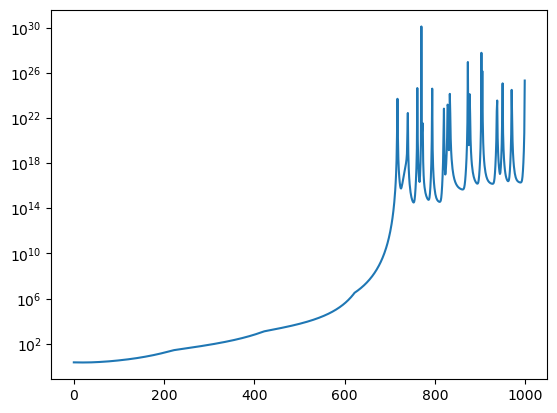

In [90]:
plt.plot(h_losses)
plt.yscale('log')

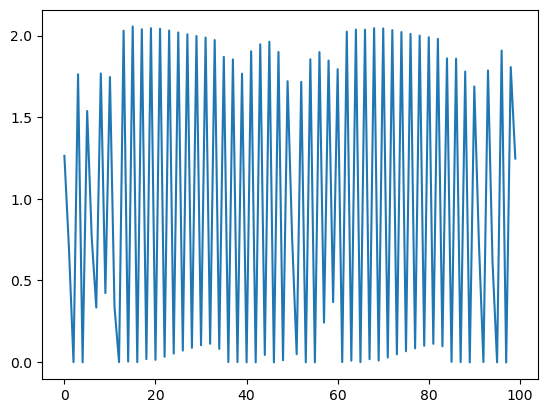

In [91]:
plt.plot(h.data)

***

# Old solver

In [9]:
Nr = 1
r = torch.ones(Nr, dtype=torch.float64, requires_grad=True)

def r_loss(r):
    # Define residual of the equation
    residual = 1/r**5 * ((r-1.5) * (1+2*r)**3)
    # Return the mean squared residual
    return torch.mean(residual**2)

In [10]:
def solve_for_r(r, N_iter=1000, lr=1.0e-3):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([r], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=200)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = r_loss(r=r)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return r, losses

In [11]:
r, r_losses = solve_for_r(r=r, N_iter=10000, lr=1.0e-3)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1385.57it/s]


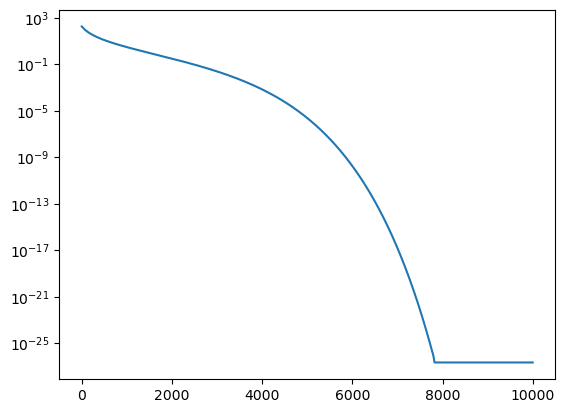

In [12]:
plt.plot(r_losses)
plt.yscale('log')

In [14]:
print(r)

tensor([1.5000], dtype=torch.float64, requires_grad=True)
